In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import random
#import warnings
#warnings.filterwarnings('ignore')

In [33]:
# Simulation Cols mapping
cols_mapping = {'InputParams': {'FEED1MASSFLOW': 'C3', 'FEED1TEMP': 'C4','PROD1MASSFLOW': 'C5','PROD1TEMP': 'C6',
                          'E1FOULING': 'C11', 'E2FOULING': 'C15'},
               'OutputParams': {'PROD1E1IN': 'C3', 'PROD1OUT': 'C4', 'FEED1E1OUT': 'C7', 'FEED1OUT': 'C8'},
               'Outputuoms': {'PROD1E1IN': 'C', 'PROD1OUT': 'C', 'FEED1E1OUT': 'C', 'FEED1OUT': 'C'}
               }
# X , y cols sorrend a fontos az ANN-hez majd
x_cols = list(cols_mapping['InputParams'].keys())
y_cols = list(cols_mapping['OutputParams'].keys())

In [34]:
sample_limits = pd.read_excel('basesampling.xlsx')

In [35]:
sample_limits

,Tagname,Lower,Upper,Cell
0,FEED1MASSFLOW,10000.00000,30000.000000,C3
1,FEED1TEMP,10.00000,35.000000,C4
2,PROD1MASSFLOW,20000.00000,60000.000000,C5
3,PROD1TEMP,90.00000,135.000000,C6
4,E1FOULING,0.00025,0.002936,C11
5,E2FOULING,0.00025,0.002936,C15


In [36]:
max_fouling = np.random.uniform(0.001 * 1.5, 0.0029 * 1)

In [37]:
max_fouling

0.0021986332520418897

In [38]:
# Set global random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

class HeatExchangerProcessGenerator:
    def __init__(self, cols_mapping, random_seed=RANDOM_SEED):
        # Set instance-specific random seed
        self.random_seed = random_seed
        self.rng = np.random.RandomState(random_seed)

        self.cols_mapping = cols_mapping
        self.x_cols = list(cols_mapping['InputParams'].keys())
        self.y_cols = list(cols_mapping['OutputParams'].keys())
        
        # Define base operating conditions
        self.base_conditions = {
            'FEED1MASSFLOW': 18000.0,  # kg/h
            'FEED1TEMP': 25.0,       # °C
            'PROD1MASSFLOW': 45000.0,   # kg/h
            'PROD1TEMP': 115.0,       # °C
            'E1FOULING': 0.00025,     # fouling factor
            'E2FOULING': 0.00025,     # fouling factor
        }
        
        # Define operating limits
        self.limits = {
            'FEED1MASSFLOW': (12000.0, 25000.0),
            'FEED1TEMP': (12.0, 33.0),
            'PROD1MASSFLOW': (32000.0, 50000.0),
            'PROD1TEMP': (95.0, 125.0),
            'E1FOULING': (0.0004, 0.0029),
            'E2FOULING': (0.0004, 0.0023),
        }

        # Define measurement noise levels (as percentage of value)
        self.noise_levels = {
            'FEED1MASSFLOW': 0.01,  # 2% noise
            'FEED1TEMP': 0.005,      # 1% noise
            'PROD1MASSFLOW': 0.01,  # 2% noise
            'PROD1TEMP': 0.005,      # 1% noise
            'E1FOULING': 0.05,      # 5% noise
            'E2FOULING': 0.05,      # 5% noise
        }
    
    def enforce_realistic_limits(self, point):
        """
        Apply more realistic limits that allow occasional small excursions beyond nominal limits
        but prevent excessive deviations (max 5%) while avoiding artificial "flat" regions
        """
        for param, value in point.items():
            if param in self.limits:
                min_val, max_val = self.limits[param]
                
                # Allow occasional excursions beyond limits, but with stricter control
                if value < min_val:
                    # Probabilistic approach to exceeding lower limit
                    # The further below the limit, the less likely to accept the value
                    excursion_ratio = (min_val - value) / min_val
                    
                    # Stricter control: maximum allowed excursion is 5% below limit
                    if excursion_ratio > 0.05:
                        # Hard cap at 5% below limit with some randomness
                        point[param] = min_val * (0.99 + 0.01 * self.rng.random())
                    # For smaller excursions, use probabilistic acceptance
                    elif excursion_ratio > 0.02 or self.rng.random() > np.exp(-10 * excursion_ratio):
                        # Apply a soft limit with some randomness
                        point[param] = min_val * (0.98 + 0.03 * self.rng.random())
                
                elif value > max_val:
                    # Probabilistic approach to exceeding upper limit
                    excursion_ratio = (value - max_val) / max_val
                    
                    # Stricter control: maximum allowed excursion is 5% above limit
                    if excursion_ratio > 0.05:
                        # Hard cap at 5% above limit with some randomness
                        point[param] = max_val * (1.00 + 0.04 * self.rng.random())
                        # Ensure it doesn't exceed 5% above max
                        point[param] = min(point[param], max_val * 1.05)
                    # For smaller excursions, use probabilistic acceptance
                    elif excursion_ratio > 0.02 or self.rng.random() > np.exp(-10 * excursion_ratio):
                        # Apply a soft limit with some randomness
                        point[param] = max_val * (0.98 + 0.03 * self.rng.random())
        
        return point



    def enforce_mass_balance(self, point):
        """
        Ensure mass balance: PROD1MASSFLOW + PROD2MASSFLOW ≤ FEED1MASSFLOW
        but allow for small imbalances that might occur in real systems
        """
        feed_flow = point['FEED1MASSFLOW']
        prod1_flow = point['PROD1MASSFLOW']
        
        # Calculate total product flow
        total_prod_flow = prod1_flow
        
        # Allow larger imbalances (±5%) to simulate measurement errors and process variations
        balance_tolerance = 0.05
        
        # If total product flow significantly exceeds feed flow, adjust product flows
        if total_prod_flow > feed_flow * (1 + balance_tolerance):
            # Add some randomness to the adjustment to avoid perfect balance
            adjustment_factor = feed_flow / total_prod_flow * (0.95 + 0.08 * self.rng.random())
            
            # Calculate adjusted flows
            adjusted_prod1 = prod1_flow * adjustment_factor
            
            # Ensure adjusted flows don't exceed their limits
            if adjusted_prod1 > self.limits['PROD1MASSFLOW'][1]:
                # If PROD1 would exceed its limit, adjust it to a random value near the limit
                adjusted_prod1 = self.limits['PROD1MASSFLOW'][1] * (0.97 + 0.03 * self.rng.random())
   
            # Apply the adjusted flows
            point['PROD1MASSFLOW'] = adjusted_prod1
        
        # Occasionally introduce a small "loss" in the system (1-3% of feed flow)
        elif self.rng.random() < 0.3:  # 30% chance of introducing loss
            current_ratio = total_prod_flow / feed_flow
            if current_ratio > 0.97:  # Only introduce loss if we're close to perfect balance
                loss_factor = self.rng.uniform(0.01, 0.03)
                adjustment_factor = (1 - loss_factor)
                point['PROD1MASSFLOW'] = prod1_flow * adjustment_factor

        
        return point

    
    def add_measurement_noise(self, point):
        """Add realistic measurement noise to each parameter"""
        noisy_point = {}
        for param, value in point.items():
            if param in self.noise_levels:
                # Add random noise based on the defined noise level for each parameter
                # Use a mix of normal and occasional non-normal noise to simulate real sensor behavior
                if np.random.random() < 0.95:  # 95% normal noise
                    noise_factor = 1 + np.random.normal(0, self.noise_levels[param])
                else:  # 5% chance of larger noise spike
                    noise_factor = 1 + np.random.normal(0, self.noise_levels[param] * 3)
                
                noisy_value = value * noise_factor
                noisy_point[param] = noisy_value
            else:
                noisy_point[param] = value
                
        return noisy_point
    
    def generate_steady_state(self, n_points, current_state, noise_level=0.01):
        """Generate steady state operation with realistic random variations"""
        data = []
        
        # Create a slightly drifting baseline to avoid perfectly flat steady states
        drift_directions = {}
        for param in current_state:
            drift_directions[param] = np.random.choice([-1, 1]) * noise_level * 0.2
        
        current_drift = current_state.copy()
        
        for i in range(n_points):
            point = {}
            
            # Every ~20 points, change drift direction for some parameters
            if i % 20 == 0:
                for param in np.random.choice(list(current_state.keys()), 
                                             size=int(len(current_state) * 0.3)):
                    drift_directions[param] *= -1
            
            for param, value in current_drift.items():
                # Apply small drift
                drift = drift_directions[param] * value
                current_drift[param] += drift
                
                # Add random process variations (mix of normal and occasional larger variations)
                if np.random.random() < 0.97:  # 97% normal variations
                    process_noise = np.random.normal(0, noise_level * value)
                else:  # 3% larger variations
                    process_noise = np.random.normal(0, noise_level * value * 3)
                
                point[param] = current_drift[param] + process_noise
            
            # Apply realistic limits instead of hard caps
            point = self.enforce_realistic_limits(point)
            
            # Enforce mass balance with realistic variations
           # point = self.enforce_mass_balance(point)
            
            # Add measurement noise
            point = self.add_measurement_noise(point)
            
            data.append(point)
            
        return data
    
    def generate_ramp_change(self, n_points, start_state, end_state):
        """Generate a gradual ramp change from start_state to end_state"""
        data = []
        
        for i in range(n_points):
            point = {}
            for param in self.x_cols:
                # Linear interpolation between start and end states
                fraction = i / (n_points - 1) if n_points > 1 else 1
                value = start_state[param] + fraction * (end_state[param] - start_state[param])
                point[param] = value
            
            # Enforce mass balance
           # point = self.enforce_mass_balance(point)
            
            # Add measurement noise
            point = self.add_measurement_noise(point)
            
            data.append(point)
            
        return data
    
    def generate_fouling_buildup(self, n_points, current_state, exchanger_id, max_fouling=None):
        """Generate gradual fouling buildup for a specific heat exchanger"""
        data = []
        fouling_param = f'E{exchanger_id}FOULING'
        
        if max_fouling is None:
            max_fouling = self.limits[fouling_param][1]
        
        start_fouling = current_state[fouling_param]
        
        for i in range(n_points):
            point = current_state.copy()
            # Exponential fouling buildup
            fraction = i / (n_points - 1) if n_points > 1 else 1
            # Using exponential growth for more realistic fouling behavior
            fouling = start_fouling + (max_fouling - start_fouling) * (np.exp(3 * fraction) - 1) / (np.exp(3) - 1)
            point[fouling_param] = min(fouling, max_fouling)
            
            # Enforce mass balance
            #point = self.enforce_mass_balance(point)
            
            # Add measurement noise
            point = self.add_measurement_noise(point)
            
            data.append(point)
            
        return data
    
    def generate_cleaning_event(self, current_state):
        """Simulate cleaning of heat exchangers by resetting fouling factors with some randomness"""
        new_state = current_state.copy()
        
        # Reset fouling with some randomness
        # After cleaning, fouling is not perfectly zero but very low with some variation
        new_state['E1FOULING'] = self.limits['E1FOULING'][0] * (1 + np.random.uniform(0, 0.5))
        new_state['E2FOULING'] = self.limits['E2FOULING'][0] * (1 + np.random.uniform(0, 0.5))

        
        # Also slightly randomize other parameters to reflect process changes during maintenance
        for param in ['FEED1MASSFLOW', 'FEED1TEMP', 'PROD1MASSFLOW', 'PROD1TEMP']:
            # Random variation of ±2%
            variation = 1 + np.random.uniform(-0.02, 0.02)
            new_state[param] = current_state[param] * variation
            # Ensure within limits
            new_state[param] = max(new_state[param], self.limits[param][0])
            new_state[param] = min(new_state[param], self.limits[param][1])
        
        # Enforce mass balance
        #new_state = self.enforce_mass_balance(new_state)
        
        return new_state
    
    def generate_process_dataset(self, n_points=730):
        """Generate a complete dataset with various process conditions and randomized changes"""
        data = []
        current_state = self.base_conditions.copy()
        
        # Start with steady state operation (first week)
        data.extend(self.generate_steady_state(30, current_state))
        
        # Increase throughput (feed flow) to a random value within limits
        target_state = current_state.copy()
        target_feed = np.random.uniform(current_state['FEED1MASSFLOW'] * 1.1, self.limits['FEED1MASSFLOW'][1])
        target_state['FEED1MASSFLOW'] = target_feed
        


        # Find a valid prod_ratio that respects both product flow limits
        valid_ratio_found = False
        attempts = 0
        while not valid_ratio_found and attempts < 10:
            prod_ratio = np.random.uniform(0.45, 0.55)  # Random split between products
            prod1_flow = target_feed * prod_ratio
            prod2_flow = target_feed * (1 - prod_ratio)
            
            # Check if both flows are within limits
            if (prod1_flow <= self.limits['PROD1MASSFLOW'][1] and 
                prod1_flow >= self.limits['PROD1MASSFLOW'][0]):
                valid_ratio_found = True
            attempts += 1

        # If we couldn't find a valid ratio, adjust to respect limits
        if not valid_ratio_found:
            
            # Set PROD1MASSFLOW to a valid value
            prod1_flow = min(max(target_feed * 0.5, self.limits['PROD1MASSFLOW'][0]), self.limits['PROD1MASSFLOW'][1])
            target_state['PROD1MASSFLOW'] = prod1_flow
   
        else:
            target_state['PROD1MASSFLOW'] = prod1_flow

        
        data.extend(self.generate_ramp_change(15, current_state, target_state))
        current_state = target_state.copy()
        
        # Steady state at higher throughput
        data.extend(self.generate_steady_state(60, current_state))
        
        # Increase feed temperature to a random value within limits
        target_state = current_state.copy()
        target_state['FEED1TEMP'] = np.random.uniform(current_state['FEED1TEMP'] * 1.05, self.limits['FEED1TEMP'][1])
        data.extend(self.generate_ramp_change(10, current_state, target_state))
        current_state = target_state.copy()
        
        # Steady state at higher temperature
        data.extend(self.generate_steady_state(45, current_state))
        
        # Gradual fouling buildup in E1 to a random max value
        max_fouling = np.random.uniform(0.001 * 1.5, self.limits['E1FOULING'][1] * 1)
        fouling_data = self.generate_fouling_buildup(90, current_state, 1, max_fouling)
        data.extend(fouling_data)
        current_state = fouling_data[-1].copy()
        
        # Return to a random normal temperature
        target_state = current_state.copy()
        target_state['FEED1TEMP'] = np.random.uniform(self.limits['FEED1TEMP'][0] * 1.05, self.limits['FEED1TEMP'][1] * 0.9)
        data.extend(self.generate_ramp_change(10, current_state, target_state))
        current_state = target_state.copy()
        
        # Steady state with fouling
        data.extend(self.generate_steady_state(40, current_state))
        
        # Cleaning event with randomized outcomes
        current_state = self.generate_cleaning_event(current_state)
        
        # Steady state after cleaning
        data.extend(self.generate_steady_state(50, current_state))
        
        # Change throughput to a random value
        target_state = current_state.copy()
        target_feed = np.random.uniform(self.limits['FEED1MASSFLOW'][0] * 1.05, current_state['FEED1MASSFLOW'] * 0.95)
        target_state['FEED1MASSFLOW'] = target_feed
        
        # Adjust product flows with limit checking
        prod_ratio = np.random.uniform(0.45, 0.55)
        prod1_flow = target_feed * prod_ratio


        # Check if flows are within limits
        if prod1_flow < self.limits['PROD1MASSFLOW'][0]:
            # Adjust ratio to meet minimum PROD1 flow
            prod1_flow = self.limits['PROD1MASSFLOW'][0]
        elif prod1_flow > self.limits['PROD1MASSFLOW'][1]:
            # Adjust ratio to meet maximum PROD1 flow
            prod1_flow = self.limits['PROD1MASSFLOW'][1]


      

        # Apply the adjusted flows
        target_state['PROD1MASSFLOW'] = prod1_flow

        
        data.extend(self.generate_ramp_change(15, current_state, target_state))
        current_state = target_state.copy()
        
        # Steady state at new throughput
        data.extend(self.generate_steady_state(60, current_state))
        
        # Gradual fouling buildup in E2 and E3 simultaneously to random values
        start_fouling = current_state.copy()
        max_fouling_e2 = np.random.uniform(0.001 * 1.5, self.limits['E2FOULING'][1] * 1)

        
        fouling_data = []
        for i in range(120):
            point = start_fouling.copy()
            fraction = i / 119  # 0 to 1
            
            # E2 fouling
            e2_fouling = start_fouling['E2FOULING'] + (max_fouling_e2 - start_fouling['E2FOULING']) * (np.exp(3 * fraction) - 1) / (np.exp(3) - 1)
            point['E2FOULING'] = min(e2_fouling, self.limits['E2FOULING'][1])
            

            
            # Add measurement noise
            point = self.add_measurement_noise(point)
            
            fouling_data.append(point)
        
        data.extend(fouling_data)
        current_state = fouling_data[-1].copy()
        
        # Return to random base throughput
        target_state = current_state.copy()
        target_feed = np.random.uniform(self.limits['FEED1MASSFLOW'][0] * 1.1, self.limits['FEED1MASSFLOW'][1] * 0.9)
        target_state['FEED1MASSFLOW'] = target_feed
        
        # Adjust product flows with limit checking
        prod_ratio = np.random.uniform(0.45, 0.55)
        prod1_flow = target_feed * prod_ratio
        prod2_flow = target_feed * (1 - prod_ratio)

        # Check if flows are within limits
        if prod1_flow < self.limits['PROD1MASSFLOW'][0]:
            # Adjust ratio to meet minimum PROD1 flow
            prod1_flow = self.limits['PROD1MASSFLOW'][0]
        elif prod1_flow > self.limits['PROD1MASSFLOW'][1]:
            # Adjust ratio to meet maximum PROD1 flow
            prod1_flow = self.limits['PROD1MASSFLOW'][1]




        # Apply the adjusted flows
        target_state['PROD1MASSFLOW'] = prod1_flow

        
        
        data.extend(self.generate_ramp_change(15, current_state, target_state))
        current_state = target_state.copy()
        
        # Final steady state with fouling
        data.extend(self.generate_steady_state(70, current_state))
        
        # Final cleaning event
        current_state = self.generate_cleaning_event(current_state)
        
        # Steady state after final cleaning
        data.extend(self.generate_steady_state(100, current_state))
        
        # Ensure we have exactly n_points
        if len(data) > n_points:
            data = data[:n_points]
        elif len(data) < n_points:
            # Add more steady state points if needed
            data.extend(self.generate_steady_state(n_points - len(data), current_state))
        
        # Convert to DataFrame with timestamps
        start_date = datetime.now() - timedelta(days=n_points)
        dates = [start_date + timedelta(days=i) for i in range(n_points)]
        
        df = pd.DataFrame(data)
        df['timestamp'] = dates
        
        return df



In [39]:
def add_process_anomalies(data, n_anomalies=5):
    """Add random process anomalies to the dataset"""
    df = data.copy()
    
    for _ in range(n_anomalies):
        # Select a random day for the anomaly
        anomaly_idx = random.randint(0, len(df) - 1)
        
        # Choose a random anomaly type
        anomaly_type = random.choice([
            'feed_flow_spike',
            'feed_temp_spike',
            'product_flow_imbalance',
            'sudden_fouling_increase'
        ])
        
        if anomaly_type == 'feed_flow_spike':
            # Sudden spike in feed flow
            df.at[anomaly_idx, 'FEED1MASSFLOW'] *= random.uniform(1.2, 1.5)
            
        elif anomaly_type == 'feed_temp_spike':
            # Sudden spike in feed temperature
            df.at[anomaly_idx, 'FEED1TEMP'] += random.uniform(5, 15)
            
        elif anomaly_type == 'product_flow_imbalance':
            # Imbalance between product flows
            factor = random.uniform(0.7, 0.9)
            df.at[anomaly_idx, 'PROD1MASSFLOW'] *= factor
            
            
        elif anomaly_type == 'sudden_fouling_increase':
            # Sudden increase in one exchanger's fouling
            exchanger = random.choice([1, 2])
            fouling_param = f'E{exchanger}FOULING'
            df.at[anomaly_idx, fouling_param] *= random.uniform(1.5, 3.0)
            
    # Ensure all values are within limits
    generator = HeatExchangerProcessGenerator(cols_mapping)
    for param in generator.limits:
        if param in df.columns:
            df[param] = df[param].clip(generator.limits[param][0], generator.limits[param][1])
    
    return df

In [40]:
RANDOM_SEED = 12
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Create the generator
generator = HeatExchangerProcessGenerator(cols_mapping, RANDOM_SEED)

# Generate the dataset
process_data = generator.generate_process_dataset(730)  # 730 days = 2 years of daily data

# Display the first few rows
print(process_data.head())

# Example usage
#process_data_with_anomalies = add_process_anomalies(process_data, n_anomalies=10)

# Plot the data with anomalies
#plot_process_data(process_data_with_anomalies)

# Save to CSV
#process_data.to_csv('heat_exchanger_process_data.csv', index=False)


   FEED1MASSFLOW  FEED1TEMP  PROD1MASSFLOW   PROD1TEMP  E1FOULING  E2FOULING  \
0   18035.534301  25.256563   45159.717210  116.560578   0.000397   0.000437   
1   17885.823383  25.102091   45784.423560  112.404756   0.000386   0.000396   
2   18346.787165  24.394746   43968.764416  114.985013   0.000385   0.000366   
3   18031.977897  25.377073   44989.791884  114.701189   0.000427   0.000388   
4   18402.514701  25.300514   44746.733476  113.177082   0.000368   0.000418   

                   timestamp  
0 2023-04-25 13:05:32.264101  
1 2023-04-26 13:05:32.264101  
2 2023-04-27 13:05:32.264101  
3 2023-04-28 13:05:32.264101  
4 2023-04-29 13:05:32.264101  


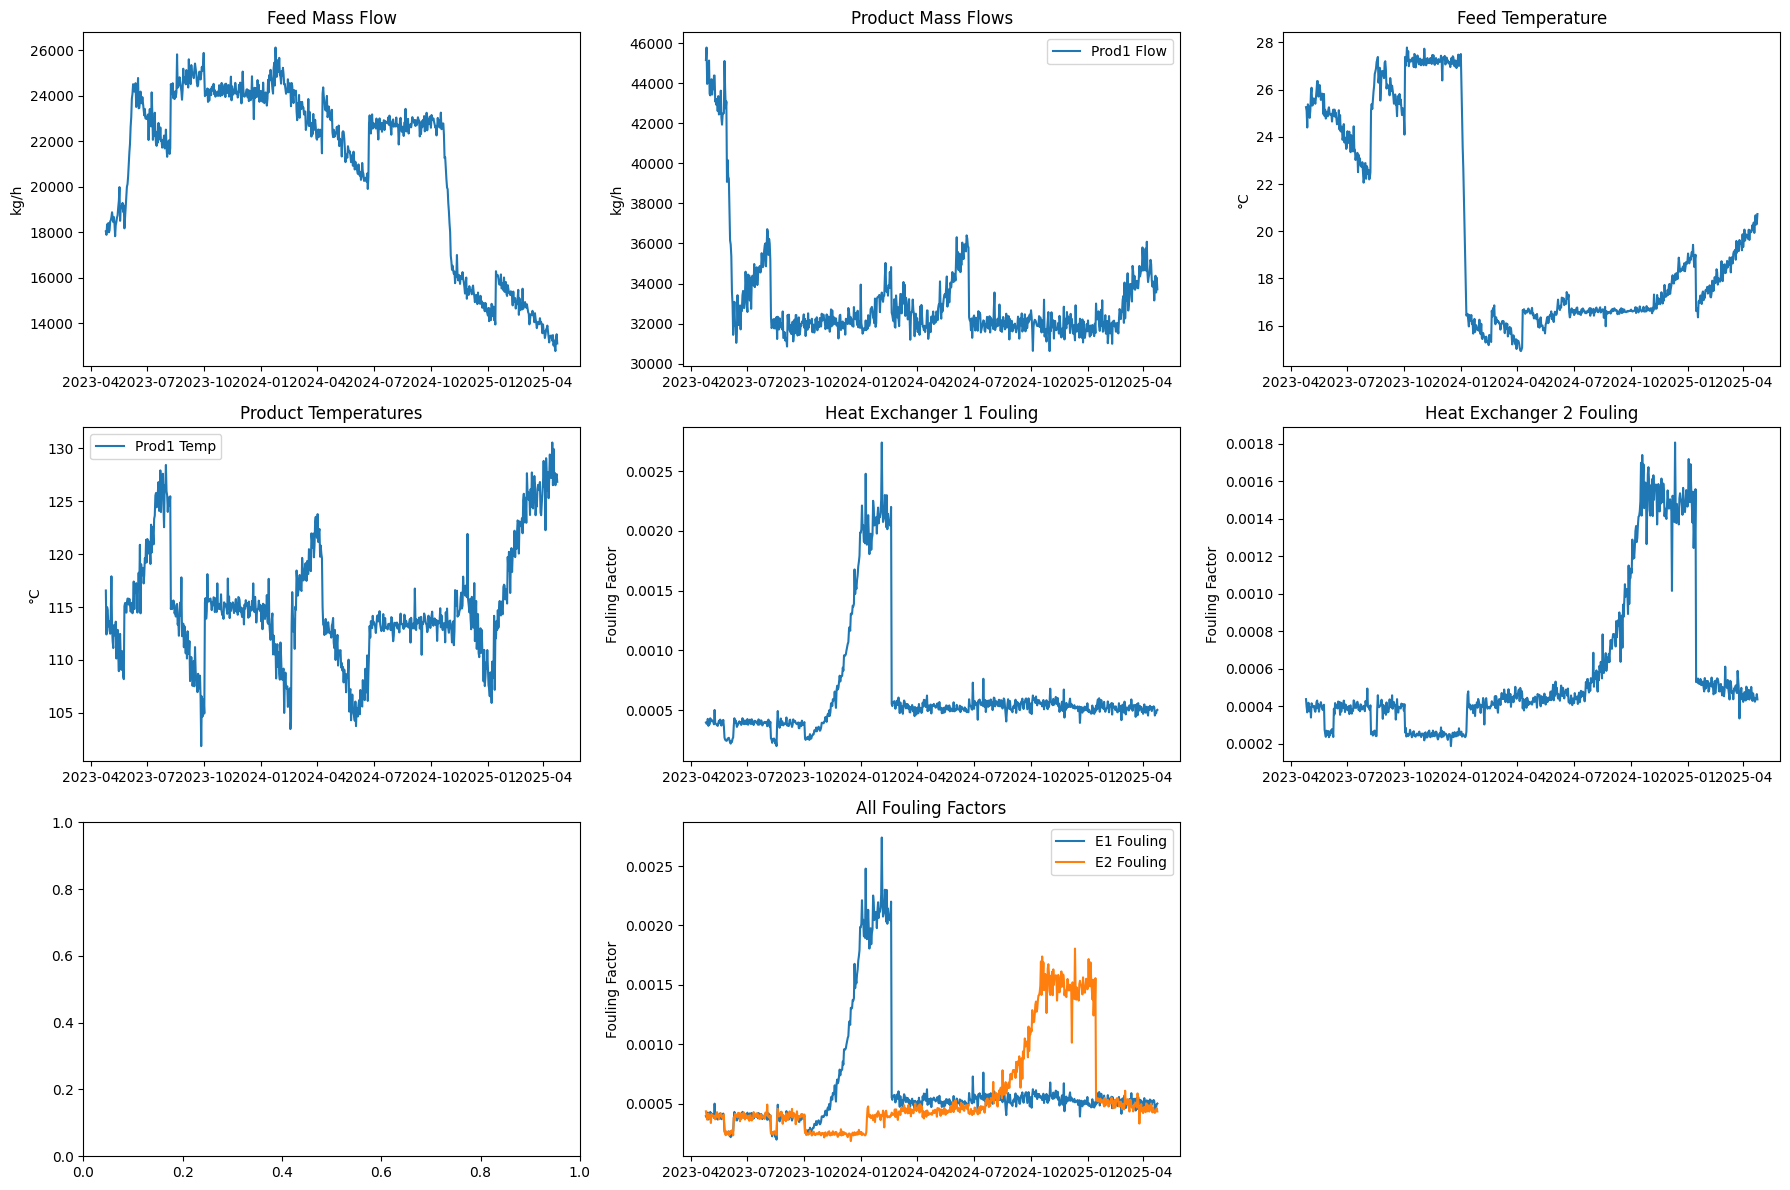

In [41]:
def plot_process_data(data):
    """Plot the generated process data to visualize the patterns"""
    fig, axs = plt.subplots(3, 3, figsize=(18, 12))
    
    # Plot flow rates
    axs[0, 0].plot(data['timestamp'], data['FEED1MASSFLOW'], label='Feed Flow')
    axs[0, 0].set_title('Feed Mass Flow')
    axs[0, 0].set_ylabel('kg/h')
    
    axs[0, 1].plot(data['timestamp'], data['PROD1MASSFLOW'], label='Prod1 Flow')

    axs[0, 1].set_title('Product Mass Flows')
    axs[0, 1].set_ylabel('kg/h')
    axs[0, 1].legend()
    
    # Plot temperatures
    axs[0, 2].plot(data['timestamp'], data['FEED1TEMP'], label='Feed Temp')
    axs[0, 2].set_title('Feed Temperature')
    axs[0, 2].set_ylabel('°C')
    
    axs[1, 0].plot(data['timestamp'], data['PROD1TEMP'], label='Prod1 Temp')

    axs[1, 0].set_title('Product Temperatures')
    axs[1, 0].set_ylabel('°C')
    axs[1, 0].legend()
    
    # Plot fouling factors
    axs[1, 1].plot(data['timestamp'], data['E1FOULING'], label='E1 Fouling')
    axs[1, 1].set_title('Heat Exchanger 1 Fouling')
    axs[1, 1].set_ylabel('Fouling Factor')
    
    axs[1, 2].plot(data['timestamp'], data['E2FOULING'], label='E2 Fouling')
    axs[1, 2].set_title('Heat Exchanger 2 Fouling')
    axs[1, 2].set_ylabel('Fouling Factor')

    
    # Add combined fouling plot
    axs[2, 1].plot(data['timestamp'], data['E1FOULING'], label='E1 Fouling')
    axs[2, 1].plot(data['timestamp'], data['E2FOULING'], label='E2 Fouling')

    axs[2, 1].set_title('All Fouling Factors')
    axs[2, 1].set_ylabel('Fouling Factor')
    axs[2, 1].legend()
    
    # Hide the unused subplot
    axs[2, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig('heat_exchanger_process_data.png', dpi=300)
    plt.show()

# Plot the generated data
plot_process_data(process_data)


In [42]:
process_data.describe()

,FEED1MASSFLOW,FEED1TEMP,PROD1MASSFLOW,PROD1TEMP,E1FOULING,E2FOULING,timestamp
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730
mean,21025.013026,20.100065,33176.319399,115.065278,0.000626,0.000579,2024-04-24 01:05:32.264101120
min,12771.858927,14.923454,30627.829769,101.854711,0.000199,0.000186,2023-04-25 13:05:32.264101
25%,18348.286178,16.597853,31848.997896,112.532671,0.000420,0.000388,2023-10-24 19:05:32.264101120
50%,22642.184853,17.832704,32245.773157,114.223131,0.000517,0.000437,2024-04-24 01:05:32.264101120
75%,23984.197619,24.955993,33428.707606,116.978514,0.000562,0.000533,2024-10-23 07:05:32.264101120
max,26123.949169,27.783056,45784.423560,130.545604,0.002740,0.001806,2025-04-23 13:05:32.264101
std,3748.472535,4.335116,2628.502232,5.389702,0.000444,0.000391,NaN


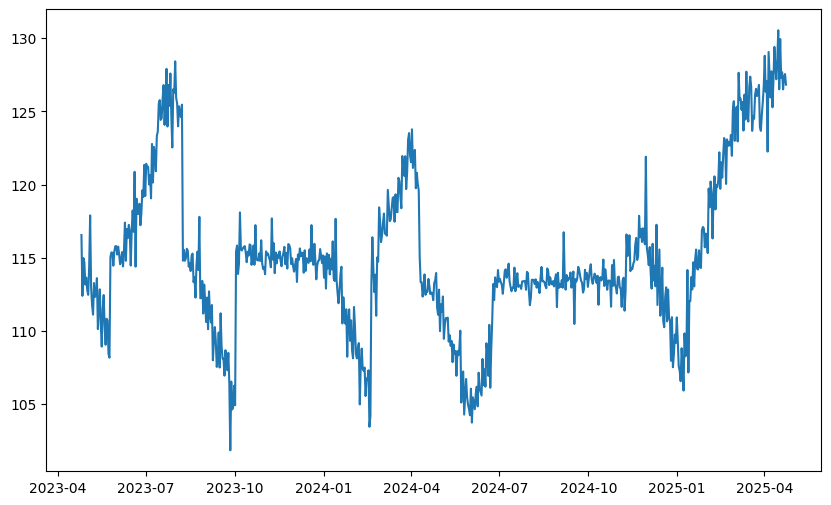

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(process_data['timestamp'], process_data['PROD1TEMP'])

In [45]:
process_data.to_excel('heat_exchanger_process_data_v4.xlsx')